In [250]:
%pylab inline

import biff
from pygadgetreader import *
from astropy import constants
from astropy import units
from scipy import interpolate
from octopus import leapfrog
from octopus import n_body_orbit


G1 = constants.G
G1 = G1.to(units.kpc**3/(units.Msun * units.Gyr**2))

G_c = constants.G
G_c = G_c.to(units.kiloparsec**3 / (units.s**2 * units.Msun)) # 

Populating the interactive namespace from numpy and matplotlib


In [252]:
font = {'size':16, 'family':'serif'}
plt.matplotlib.rc('font', **font)

In [3]:
## Code taken from (https://github.com/adrn/biff/blob/master/notebooks/Plummer%20test.ipynb)
def STnlm(xyz, mass, rs, n_max, l_max):
    nmax = n_max
    lmax = l_max

    Snlm = np.zeros((nmax+1,lmax+1,lmax+1))
    Tnlm = np.zeros((nmax+1,lmax+1,lmax+1))

    nlms = []

    for n in range(nmax+1):
        for l in range(lmax+1):
            for m in range(l+1):
                nlms.append([n,l,m])

    for nlm in nlms:
        n,l,m = nlm
        S,T = biff.compute_coeffs_discrete(np.double(xyz), np.double(mass/100.0), nlm, rs)
        Snlm[n,l,m] = S
        Tnlm[n,l,m] = T
    return Snlm, Tnlm, nlms

In [30]:
path_mwlmc = '../data/LMCMW/MWmLMC6/H1/'
snap_mwlmc = 'MWfLMC6H1'

path_mw = '../data/MW_models/pm/'
snap_mw = 'MWN2vir'

In [5]:
def evaluate_coeff(path, snap_name, snap_n, rs, n_max, l_max, rcm_MW):
    LMCMW_pos = readsnap(path + snap_name + '_{:03d}.hdf5'.format(snap_n), 'pos', 'dm')
    LMCMW_mass = readsnap(path + snap_name + '_{:03d}.hdf5'.format(snap_n), 'mass', 'dm')
    # Transforming to galactocentric coordinates.
    LMCMW_pos[:,0] -= rcm_MW[0]
    LMCMW_pos[:,1] -= rcm_MW[1]
    LMCMW_pos[:,2] -= rcm_MW[2]

    SMWLMC, TMWLMC, nlmsMWLMC = STnlm(LMCMW_pos, LMCMW_mass, rs, n_max, l_max)
    SMWLMC = reshape(SMWLMC, (size(SMWLMC)))
    TMWLMC = reshape(TMWLMC, (size(TMWLMC)))
    return SMWLMC, TMWLMC

In [6]:
def ST_interpol(path, snap_name, nmax, lmax, n_snap, h, dt_snap, rcm_mw):
    #n_snap = 8
    #nmax = 1
    #lmax = 1
    #dt_snap = 0.02
    #h = 0.001
    # Number of coefficients Snlm / Tnlm
    n_coeff = ((nmax+1)*(lmax+1)*(lmax+1))
    # S, T matrices, rows: time / cols: Number of coefficients
    S_matrix = np.zeros((n_snap, n_coeff))
    T_matrix = np.zeros((n_snap, n_coeff))
    # Finish this orbit upload!!
    #rcm_mw, vcm_mw, rcm_lmc, vcm_lmc = np.loadtxt('../data/orbits/')
    # Filling the matrix with the coefficients form the N-body sim.
    for i in range(n_snap):
        S_matrix[i], T_matrix[i] = evaluate_coeff(path, snap_name, i, 40.3, nmax, lmax, rcm_mw[i])

    # time: Time between every snapshot
    time = np.linspace(0, dt_snap*(n_snap-1), n_snap)
    # N_interp: Number of times in the interpolation (this depent in the resolution of the leapfrog integration h)
    N_interp = (dt_snap*(n_snap-1)/h)+1
    # t: Time between every time step in the interpolation
    t = np.linspace(0, dt_snap*(n_snap-1), N_interp)

    #S_matrix_interp: Matrix with the new interpolated Snlm (times, Svalues)
    S_matrix_interp = np.zeros((len(t), n_coeff))
    T_matrix_interp = np.zeros((len(t), n_coeff))
    # Interpolating 
    for i in range(n_coeff):
        fs = interpolate.interp1d(time, S_matrix[:,i], kind='linear')
        ft = interpolate.interp1d(time, T_matrix[:,i], kind='linear')
        S_matrix_interp[:,i]= fs(t)
        T_matrix_interp[:,i]= ft(t)
    
    S_new = reshape(S_matrix_interp, (N_interp, nmax+1, lmax+1, lmax+1))
    T_new = reshape(T_matrix_interp, (N_interp, nmax+1, lmax+1, lmax+1))
    
    return S_new, T_new
    


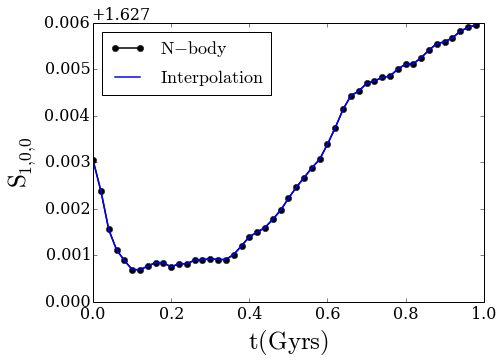

In [129]:
figure(figsize=(7, 5))
plot(time, S_matrix[:,0], 'o', lw=1.5, c='k', ls='-', label='$\mathrm{N-body}$')
plot(t, S, lw=1.5, c='b', label='$\mathrm{Interpolation}$')
legend(loc='best', fontsize=18)
xlabel('$\mathrm{t(Gyrs)}$', fontsize=25)
ylabel('$\mathrm{S_{1,0,0}}$', fontsize=25)


In [219]:
data_cmMW = np.loadtxt('LMC_orbit/orbits/LMC6_H1.txt')
time_MW = data_cmMW[:51, 0]
xcm_mw = data_cmMW[:101,5]
ycm_mw = data_cmMW[:101,6]
zcm_mw = data_cmMW[:101,7]
xcm_LMC = data_cmMW[:51, 2]
ycm_LMC = data_cmMW[:51, 3]
zcm_LMC = data_cmMW[:51, 4]

Rcm = np.array([xcm_mw, ycm_mw, zcm_mw])
Rcm = Rcm.T
print Rcm[0]

[-0.000712  0.030928  0.005486]


In [28]:
S_MW, T_MW = ST_interpol(path_mw, snap_mw, 1, 0, 21, 0.001, 0.1, np.zeros((50,3)))

Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass


In [163]:
porbit1 = n_body_orbit.particle_orbit('../data/MW_models/pm/', 'MWN2vir', 50, 260, 2.1, 0.0, 0.1)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
minimum velocity:  9.63767 km/s
maximum velocity:  402.493 km/s
Initial position (kpc): [[ 39.88428497  11.79346085 -27.1821785 ]]
Initial velocity (km/s): [[-163.53018188   75.63887787 -187.44244385]]
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returni

In [142]:
t_hex1_c, x_hex1_c, y_hex1_c, z_hex1_c, vx_hex1_c, vy_hex1_c, vz_hex1_c = leapfrog.integrate_biff_t(39.88428497, 11.79346085, -27.1821785,
                                                                                                    -163.53018188, 75.63887787,-187.44244385
                                                                                                    , 2, S_test, T_test, 1, 0, G1.value, 1.55E12, 40.85)

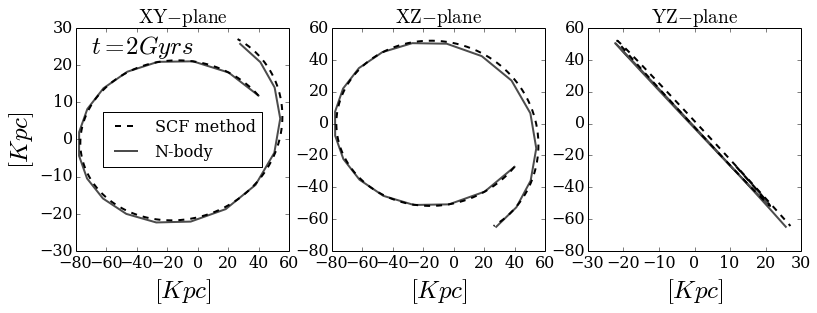

In [254]:
figure(figsize=(13,4))
subplot(1, 3, 1)
title("$\mathrm{XY-plane}$")
text(-70, 23,"$t=2Gyrs$", fontsize=25)
plot(x_hex1_c, y_hex1_c, lw=2, label='SCF method', c='k', ls='--')
plot(porbit1[:,0], porbit1[:,1], lw=2, label='N-body', c='k',alpha=0.7)
xlabel('$[Kpc]$', fontsize=25)
ylabel('$[Kpc]$', fontsize=25)
legend(loc='best', fontsize=16)

subplot(1, 3, 2)
title("$\mathrm{XZ-plane}$")
plot(x_hex1_c, z_hex1_c, lw=2, label='SCF method', c='k', ls='--')
plot(porbit1[:,0], porbit1[:,2], lw=2, label='N-body', c='k',alpha=0.7)
xlabel('$[Kpc]$', fontsize=25)

subplot(1, 3, 3)
title("$\mathrm{YZ-plane}$")
plot(y_hex1_c, z_hex1_c, lw=2, label='SCF method', c='k', ls='--')
plot(porbit1[:,1], porbit1[:,2], lw=2, label='N-body', c='k',alpha=0.7)
xlabel('$[Kpc]$', fontsize=25)

plt.savefig('orbits_mw_SCF.png', bbox_inches='tight', dpi=300)


In [216]:
porbit2 = n_body_orbit.particle_orbit('../data/MW_models/pm/', 'MWN2vir', 100, 200, 2.1, 0.0, 0.1)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
minimum velocity:  5.11766 km/s
maximum velocity:  320.275 km/s
Initial position (kpc): [[ 29.32727432  80.71829224  51.13707733]]
Initial velocity (km/s): [[  19.34353638    7.67407036 -198.95523071]]
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returni

In [166]:
t_hex2_c, x_hex2_c, y_hex2_c, z_hex2_c, vx_hex2_c, vy_hex2_c, vz_hex2_c = leapfrog.integrate_biff_t(29.32727432,  80.71829224,  51.13707733,
                                                                                                    19.34353638, 7.67407036, -198.95523071
                                                                                                    , 2, S_test, T_test, 1, 0, G1.value, 1.55E12, 40.85)

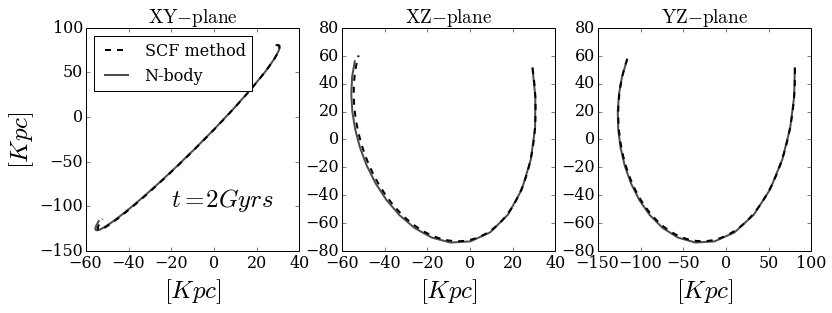

In [170]:
figure(figsize=(13,4))
subplot(1, 3, 1)
title("$\mathrm{XY-plane}$")
text(-20, -100,"$t=2Gyrs$", fontsize=25)
plot(x_hex2_c, y_hex2_c, lw=2, label='SCF method', c='k', ls='--')
plot(porbit2[:,0], porbit2[:,1], lw=2, label='N-body', c='k',alpha=0.7)
xlabel('$[Kpc]$', fontsize=25)
ylabel('$[Kpc]$', fontsize=25)
legend(loc='best', fontsize=16)

subplot(1, 3, 2)
title("$\mathrm{XZ-plane}$")
plot(x_hex2_c, z_hex2_c, lw=2, label='SCF method', c='k', ls='--')
plot(porbit2[:,0], porbit2[:,2], lw=2, label='N-body', c='k',alpha=0.7)
xlabel('$[Kpc]$', fontsize=25)

subplot(1, 3, 3)
title("$\mathrm{YZ-plane}$")
plot(y_hex2_c, z_hex2_c, lw=2, label='SCF method', c='k', ls='--')
plot(porbit2[:,1], porbit2[:,2], lw=2, label='N-body', c='k',alpha=0.7)
xlabel('$[Kpc]$', fontsize=25)

# MWLMC orbit integration

In [220]:
S_MWLMC, T_MWLMC = ST_interpol(path_mwlmc, snap_mwlmc, 5, 5, 101, 0.001, 0.02, Rcm)

Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM 

In [224]:
porbit3 = n_body_orbit.particle_orbit('../data/LMCMW/MWmLMC6/H1/', 'MWfLMC6H1', 50, 260, 2.1, 0.0, 0.02)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
minimum velocity:  9.63767 km/s
maximum velocity:  402.493 km/s
Initial position (kpc): [[ 39.88428497  11.79346085 -27.1821785 ]]
Initial velocity (km/s): [[-163.53018188   75.63887787 -187.44244385]]
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returni

In [227]:
t_hex3_c, x_hex3_c, y_hex3_c, z_hex3_c, vx_hex3_c, vy_hex3_c, vz_hex3_c = leapfrog.integrate_biff_t(39.88428497,  11.79346085, -27.1821785,
                                                                                                    -163.53018188, 75.63887787, -187.44244385
                                                                                                    , 2, S_MWLMC, T_MWLMC, 5, 5, G1.value, 1.55E12, 40.85)

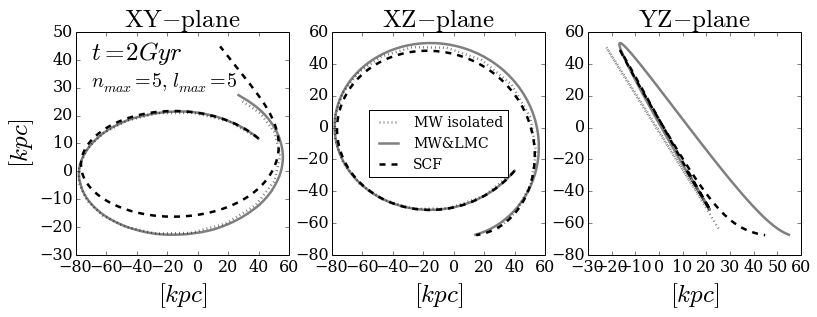

In [263]:
figure(figsize=(13,4))
subplot(1, 3, 1)
title("$\mathrm{XY-plane}$", fontsize=25)
text(-70, 30, '$n_{max}=5,\ l_{max}=5$', fontsize=20)
text(-70, 40,'$t=2Gyr$', fontsize=25)
plot(porbit1[:21,0], porbit1[:21,1], lw=2.5, ls=':', c='k', alpha=0.5, label='N-body isolated')
plot(porbit3[:-4,0]-Rcm[:,0], porbit3[:-4,1]-Rcm[:,1], lw=2.5, ls='-', c='k', alpha=0.5, label='N-body MW&LMC')
plot(x_hex3_c, y_hex3_c, lw=2.5, ls='--', c='k', label='SCF MW&LMC')
#legend(loc='lower left' ,fontsize=15)
#xlim(-90, 90)
#ylim(-50, 50)
xlabel('$[kpc]$', fontsize=25)
ylabel('$[kpc]$', fontsize=25)


subplot(1, 3, 2)
title("$\mathrm{XZ-plane}$", fontsize=25)
plot(porbit1[:21,0], porbit1[:21,2], lw=2.5, ls=':', c='k', alpha=0.5, label='MW isolated')
plot(porbit3[:,0], porbit3[:,2], lw=2.5, ls='-', c='k', alpha=0.5, label='MW&LMC')
plot(x_hex3_c, z_hex3_c, lw=2.5, ls='--', c='k', label='SCF')
#xlim(-90, 90)
#ylim(-60, 60)
legend(loc='best', fontsize=14)
xlabel('$[kpc]$', fontsize=25)

subplot(1, 3, 3)
title("$\mathrm{YZ-plane}$", fontsize=25)
plot(porbit1[:21,1], porbit1[:21,2], lw=2.5, ls=':', c='k', alpha=0.5, label='MW isolated')
plot(porbit3[:,1], porbit3[:,2], lw=2.5, ls='-', c='k', alpha=0.5, label='MW+LMC isolated')
plot(y_hex3_c, z_hex3_c, lw=2.5, ls='--', c='k', label='SCF')
#xlim(-25, 25)
#ylim(-50, 50)
xlabel('$[kpc]$', fontsize=25)

plt.savefig('orbits_mwlmc_SCF.png', bbox_inches='tight', dpi=300)



In [235]:
porbit4 = n_body_orbit.particle_orbit('../data/LMCMW/MWmLMC6/H1/', 'MWfLMC6H1', 100, 200, 2, 0.0, 0.02)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
minimum velocity:  5.11766 km/s
maximum velocity:  320.275 km/s
Initial position (kpc): [[ 29.32727432  80.71829224  51.13707733]]
Initial velocity (km/s): [[  19.34353638    7.67407036 -198.95523071]]
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returni

In [236]:
t_hex4_c, x_hex4_c, y_hex4_c, z_hex4_c, vx_hex4_c, vy_hex4_c, vz_hex4_c = leapfrog.integrate_biff_t(29.32727432, 80.71829224, 51.13707733,
                                                                                                    19.34353638, 7.67407036, -198.95523071
                                                                                                    , 2, S_MWLMC, T_MWLMC, 5, 5, G1.value, 1.55E12, 40.85)

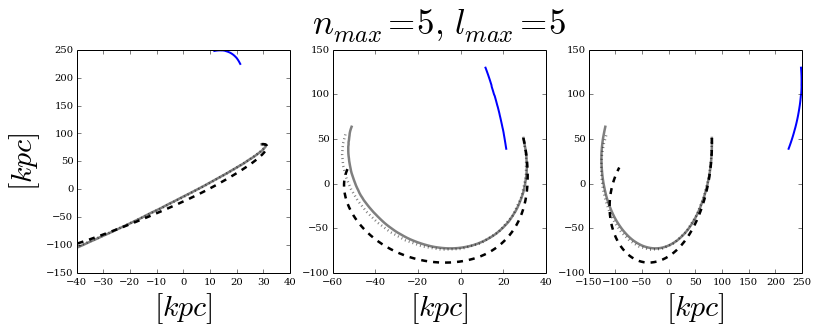

In [240]:
figure(figsize=(13,4))
subplot(1, 3, 1)
#text(-25, 80,'$t=1Gyr$', fontsize=30)
plot(porbit2[:21,0], porbit2[:21,1], lw=2.5, ls=':', c='k', alpha=0.5, label='$N-body$')
plot(porbit4[:,0]-Rcm[:-1,0], porbit4[:,1]-Rcm[:-1,1], lw=2.5, ls='-', c='k', alpha=0.5, label='$N-body$')

plot(x_hex4_c, y_hex4_c, lw=2.5, ls='--', c='k', label='$SCF$')
plot(xcm_LMC, ycm_LMC, lw='2', c='b')
#scatter(xcm_LMC[0], ycm_LMC[0], s=800, marker='*')
#scatter(xcm_LMC[-1], ycm_LMC[-1], s=600, marker='o', alpha=0.7)
xlim(-40, 40)
#ylim(-50, 50)
#legend(loc='best', fontsize=30)
xlabel('$[kpc]$', fontsize=30)
ylabel('$[kpc]$', fontsize=30)


subplot(1, 3, 2)
title('$n_{max}=5,\ l_{max}=5$', fontsize=35, y=1.05)
plot(porbit2[:21,0], porbit2[:21,2], lw=2.5, ls=':', c='k', alpha=0.5)
plot(porbit4[:,0]-Rcm[:-1,0], porbit4[:,2]-Rcm[:-1,2], lw=2.5, ls='-', c='k', alpha=0.5)
plot(x_hex4_c, z_hex4_c, lw=2.5, ls='--', c='k')
plot(xcm_LMC, zcm_LMC, lw='2', c='b')
#scatter(xcm_LMC[0], zcm_LMC[0], s=800, marker='*')
#scatter(xcm_LMC[-1], zcm_LMC[-1], s=600, marker='o', alpha=0.7)
#scatter(xcm_LMC)
#xlim(-40, 40)
#ylim(-60, 60)
xlabel('$[kpc]$', fontsize=30)

subplot(1, 3, 3)
plot(porbit2[:21,1], porbit2[:21,2], lw=2.5, ls=':', c='k', alpha=0.5)
plot(porbit4[:,1]-Rcm[:-1,1], porbit4[:,2]-Rcm[:-1,2], lw=2.5, ls='-', c='k', alpha=0.5)
plot(y_hex4_c, z_hex4_c, lw=2.5, ls='--', c='k')
plot(ycm_LMC, zcm_LMC, lw='2', c='b')
#scatter(ycm_LMC[0], zcm_LMC[0], s=800, marker='*')
#scatter(ycm_LMC[-1], zcm_LMC[-1], s=600, marker='o', alpha=0.7)
#xlim(-25, 25)
#ylim(-50, 50)
xlabel('$[kpc]$', fontsize=30)


In [251]:
porbit5 = n_body_orbit.particle_orbit('../data/LMCMW/MWmLMC6/H1/', 'MWfLMC6H1', 151, 150, 2, 0.0, 0.02)
porbit6 = n_body_orbit.particle_orbit(path_mw, snap_mw, 151, 150, 2, 0.0, 0.1)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
minimum velocity:  4.99232 km/s
maximum velocity:  272.964 km/s
Initial position (kpc): [[ -58.2070694    83.83227539  111.37786102]]
Initial velocity (km/s): [[  -5.7547431     5.07553816 -149.79179382]]
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Retu

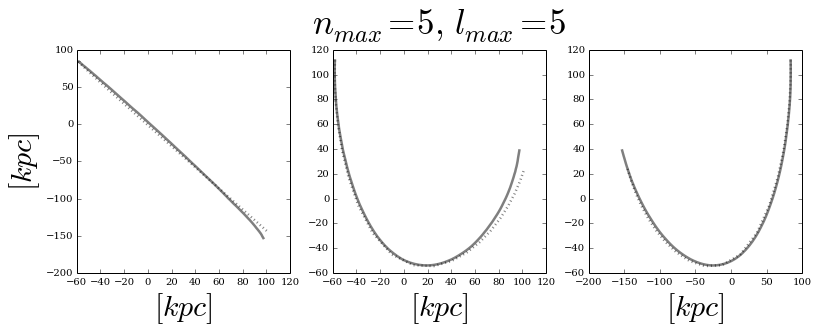

In [249]:
figure(figsize=(13,4))
subplot(1, 3, 1)
#text(-25, 80,'$t=1Gyr$', fontsize=30)
plot(porbit6[:21,0], porbit6[:21,1], lw=2.5, ls=':', c='k', alpha=0.5, label='$N-body$')
plot(porbit5[:,0]-Rcm[:-1,0], porbit5[:,1]-Rcm[:-1,1], lw=2.5, ls='-', c='k', alpha=0.5, label='$N-body$')

#plot(x_hex4_c, y_hex4_c, lw=2.5, ls='--', c='k', label='$SCF$')
#plot(xcm_LMC, ycm_LMC, lw='2', c='b')
#scatter(xcm_LMC[0], ycm_LMC[0], s=800, marker='*')
#scatter(xcm_LMC[-1], ycm_LMC[-1], s=600, marker='o', alpha=0.7)
#xlim(-40, 40)
#ylim(-50, 50)
#legend(loc='best', fontsize=30)
xlabel('$[kpc]$', fontsize=30)
ylabel('$[kpc]$', fontsize=30)


subplot(1, 3, 2)
title('$n_{max}=5,\ l_{max}=5$', fontsize=35, y=1.05)
plot(porbit6[:21,0], porbit6[:21,2], lw=2.5, ls=':', c='k', alpha=0.5)
plot(porbit5[:,0]-Rcm[:-1,0], porbit5[:,2]-Rcm[:-1,2], lw=2.5, ls='-', c='k', alpha=0.5)
#plot(x_hex4_c, z_hex4_c, lw=2.5, ls='--', c='k')
#plot(xcm_LMC, zcm_LMC, lw='2', c='b')
#scatter(xcm_LMC[0], zcm_LMC[0], s=800, marker='*')
#scatter(xcm_LMC[-1], zcm_LMC[-1], s=600, marker='o', alpha=0.7)
#scatter(xcm_LMC)
#xlim(-40, 40)
#ylim(-60, 60)
xlabel('$[kpc]$', fontsize=30)

subplot(1, 3, 3)
plot(porbit6[:21,1], porbit6[:21,2], lw=2.5, ls=':', c='k', alpha=0.5)
plot(porbit5[:,1]-Rcm[:-1,1], porbit5[:,2]-Rcm[:-1,2], lw=2.5, ls='-', c='k', alpha=0.5)
#plot(y_hex4_c, z_hex4_c, lw=2.5, ls='--', c='k')
#plot(ycm_LMC, zcm_LMC, lw='2', c='b')
#scatter(ycm_LMC[0], zcm_LMC[0], s=800, marker='*')
#scatter(ycm_LMC[-1], zcm_LMC[-1], s=600, marker='o', alpha=0.7)
#xlim(-25, 25)
#ylim(-50, 50)
xlabel('$[kpc]$', fontsize=30)
